## FINAL PROJECT - 02456 DEEP LEARNING
### SEGMENTATION OF CAR PARTS 
### COLLABORATION WITH DELOITTE CONSULTING

#### Authors
>*Sanem Leblebici - s222448*

>*Michal Lehwark - s222999*

>*Ari Menachem - s163956*

>*Elli Georgiou - s223408*


In [1]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
from modules.model import UNET
from modules.settings import COLAB_PATH, NUM_EPOCHS,BATCH_SIZE,SPLIT_RATIO, LEARNING_RATE, device
from modules.utils import get_data_loaders
from modules.resizeImages import resize_with_pad
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
import cv2
from typing import Tuple
from torchsummary import summary


2023-11-21 15:34:55.789655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the trained model

In [8]:
mdl = UNET()

## Can uncomment the next line if your device has gpu
# mdl.load_state_dict(torch.load('./models/unet_nov18.pth'))

mdl.load_state_dict(torch.load('./models/nov21/unet_nov21_4.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### TEST LOOP

Size of the test image  1  :  (256, 256, 3)
Test prediction completed for image  1
Size of the test image  2  :  (256, 256, 3)
Test prediction completed for image  2
Size of the test image  3  :  (256, 256, 3)
Test prediction completed for image  3
Size of the test image  4  :  (256, 256, 3)
Test prediction completed for image  4
Size of the test image  5  :  (256, 256, 3)
Test prediction completed for image  5
Size of the test image  6  :  (256, 256, 3)
Plotting test image  6


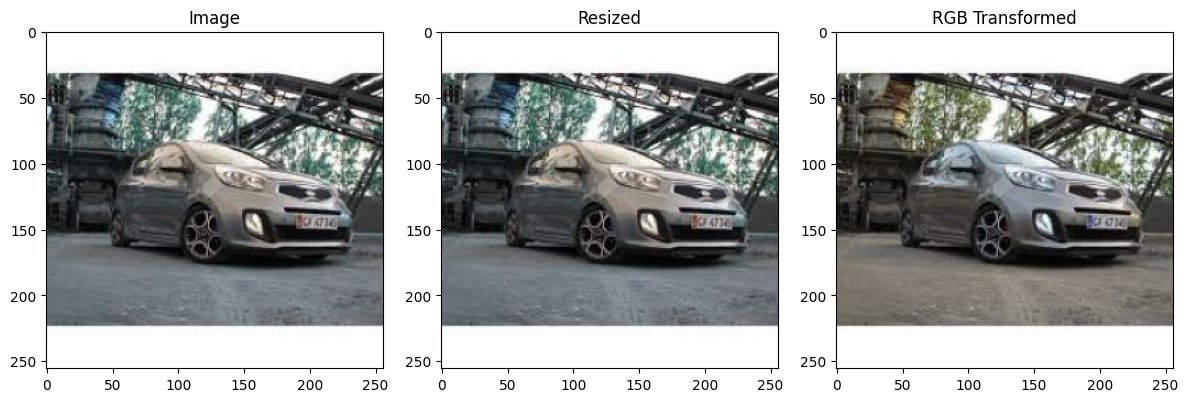

Test prediction completed for image  6
Size of the test image  7  :  (256, 256, 3)
Test prediction completed for image  7
Size of the test image  8  :  (256, 256, 3)
Test prediction completed for image  8
Size of the test image  9  :  (256, 256, 3)
Test prediction completed for image  9
Size of the test image  10  :  (256, 256, 3)
Test prediction completed for image  10
Size of the test image  11  :  (256, 256, 3)


In [9]:

test_folder_path = './data/carseg_data/images/photo/no_segmentation'  # Replace with the actual path
masks_path = './data/carseg_data/arrays'

# Create a list to store the model outputs
model_outputs = []
model_outputs_images = []
model_outputs_gt = []

# Set the model to evaluation mode
mdl.eval()

# Define the transformation to be applied to the input images
transform = transforms.Compose([transforms.ToTensor()])
how_many_images_to_test = 10
index = 0

# Iterate through the images in the test folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(test_folder_path, filename)
        
        name, ext = filename.split('.')
        mask_string = "photo_" + name + ".npy"
        mask_path = os.path.join(masks_path, mask_string)
        mask = np.load(mask_path)
        mask = mask//10
        
        img = cv2.imread(image_path)
        print("Size of the test image ", index+1, " : ", img.shape)
        resized = resize_with_pad(img, (256, 256))
        img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        # Apply the specified transformations
        input_image = transform(img_rgb).unsqueeze(0)  # Add batch dimension
        
        # show an example image at an index
        if index == 5:
          print("Plotting test image ", index+1)
          fig, axes = plt.subplots(1, 3, figsize=(12, 4))
          axes[0].imshow(img)
          axes[0].set_title('Image')
          axes[1].imshow(resized)
          axes[1].set_title('Resized')
          axes[2].imshow(img_rgb)
          axes[2].set_title('RGB Transformed')
          plt.tight_layout()
          plt.show()

        # Make the prediction
        with torch.no_grad():
            output = mdl(input_image)

        # Store the output in the list
        model_outputs.append(output)
        model_outputs_images.append(img_rgb)
        model_outputs_gt.append(mask)

        #detect for first 10 images
        if index == how_many_images_to_test:
          break
        index = index + 1
        print("Test prediction completed for image ", index)

# The `model_outputs` list now contains the model's output for each test image

### INVESTIGATING OUTPUT SHAPE

In [25]:
print("output shape ", model_outputs[2].shape)
print("output unique ", torch.unique(model_outputs[5]))
for i in range(10):
  #print(model_outputs[2][0][i])
  print(max(model_outputs[2][0][i].unique()))

# softmax_output = torch.nn.functional.softmax(model_outputs[5], dim=1)
# print("softmax shape ", softmax_output.shape)
# print("softmax unique ", torch.unique(softmax_output))
argmax_output = torch.argmax(model_outputs[2], dim=1)
print("argmax shape ", argmax_output.shape)
print("argmax unique ", torch.unique(argmax_output))

output = []
for out in model_outputs:
  softmax_output = torch.nn.functional.softmax(out, dim=1)
  argmax_output = torch.argmax(softmax_output, dim=1).long()
  print("argmax unique ", torch.unique(argmax_output))
  output.append(argmax_output)

output shape  torch.Size([1, 10, 256, 256])
output unique  tensor([4.1384e-05, 4.2337e-05, 4.2355e-05,  ..., 9.8918e-01, 9.8933e-01,
        9.8933e-01])
tensor(0.9863)
tensor(0.0719)
tensor(0.0576)
tensor(0.0477)
tensor(0.0456)
tensor(0.0651)
tensor(0.0187)
tensor(0.0275)
tensor(0.0547)
tensor(0.2433)
argmax shape  torch.Size([1, 256, 256])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])
argmax unique  tensor([0])


### COLORFUL SEGMENTATION PLOT AND LOSS PLOTS

In [12]:
def plot_loss_from_txt(file_path):
    # Read data from the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract data from each line
    indices, train_losses, val_losses = [], [], []
    for line in lines[1:]:  # Assuming the first line contains column headers
        index, train_loss, val_loss = map(float, line.strip().split())
        indices.append(index)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(indices, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(indices, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

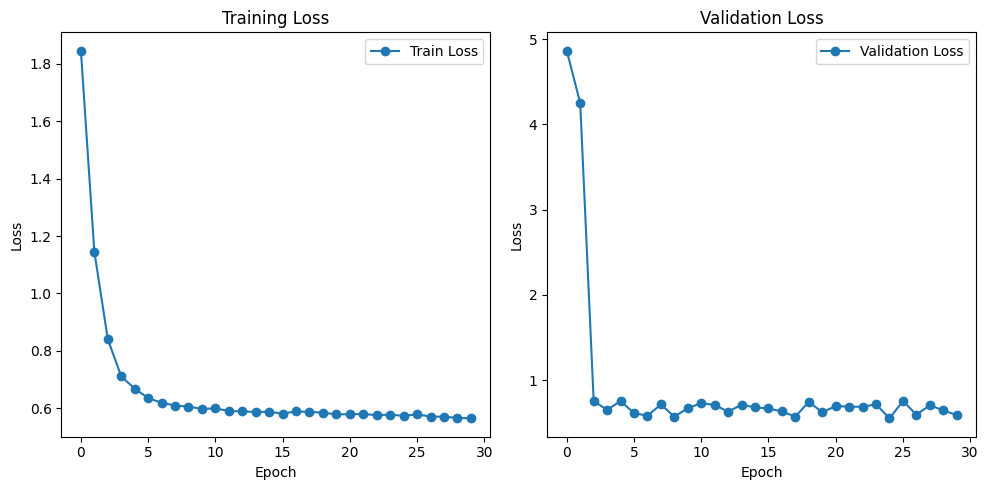

In [14]:
plot_loss_from_txt('./models/nov21/loss_data_nov21_4.txt')

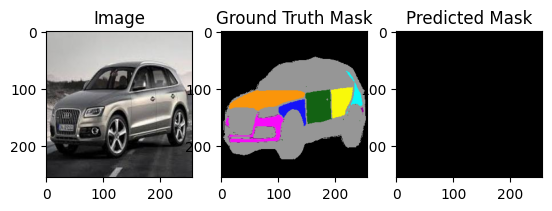

In [15]:
# Define color mapping for each class
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

def colorize_segmentation_mask(segmentation_tensor_or_mask, mask = False):
    # Convert the PyTorch tensor to a NumPy array
    if mask == False:
        segmentation_array = segmentation_tensor.squeeze(0).cpu().numpy()
        
    else:
        segmentation_array = segmentation_tensor_or_mask[:, :, 3]

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

image_index_to_display = 0
# Example usage:
# Assuming `model_outputs` is a list containing tensors with shapes [1, 10, 256, 256]
segmentation_tensor = output[image_index_to_display]  # Assuming we're using the output of the first image

plt.subplot(1, 3, 1)
plt.imshow(model_outputs_images[image_index_to_display])
plt.title('Image')

plt.subplot(1, 3, 2)
# img_rgb = cv2.cvtColor(model_outputs_images[image_index_to_display], cv2.COLOR_BGR2RGB)
plt.imshow(colorize_segmentation_mask(model_outputs_gt[image_index_to_display], True))
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
colored_mask = colorize_segmentation_mask(segmentation_tensor)
plt.imshow(colored_mask)
plt.title('Predicted Mask')

plt.show()

### TESTING THE PREPROCESSING OF THE MASK

torch.Size([10, 256, 256])
Loss 130.72914123535156
output shape  torch.Size([10, 256, 256])
output unique  tensor([0., 1.])
argmax shape  torch.Size([10, 256, 256])
argmax unique  tensor([0])


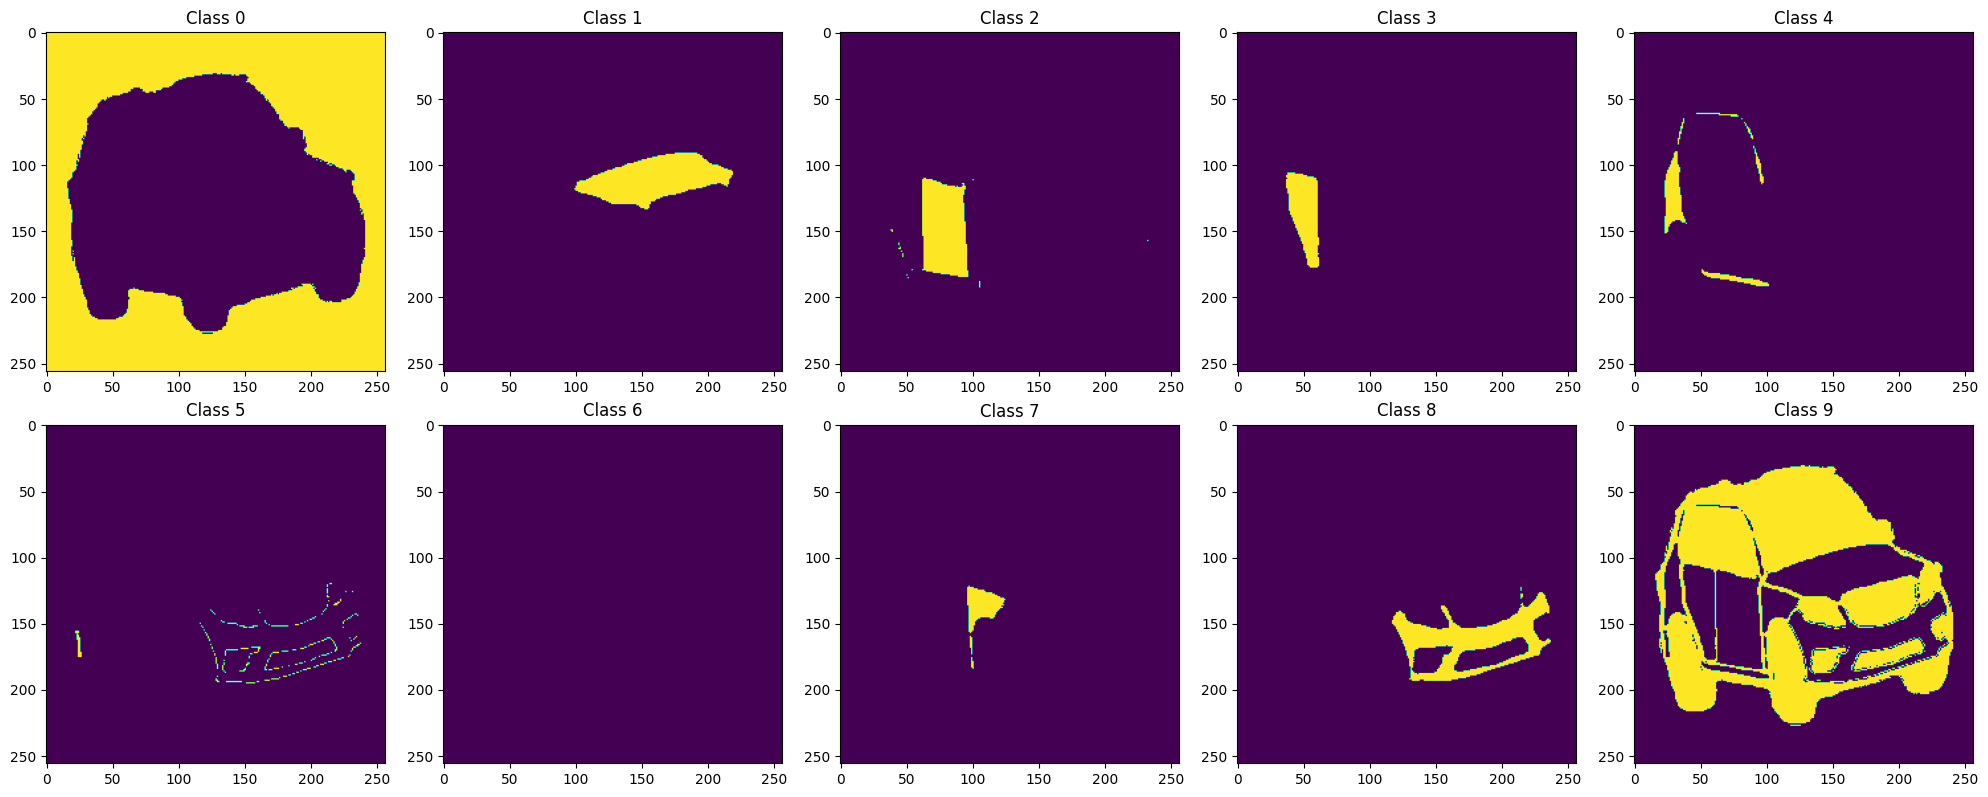

In [86]:
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }


#### WHAT WE DO IN DATASET ######
img_path = './data/carseg_data/images/photo/no_segmentation/0009.jpg'
mask_path = './data/carseg_data/arrays/photo_0009.npy'

img = np.array(Image.open(img_path))
mask = np.load(mask_path).astype(np.double)

# Convert to PyTorch tensors
mask_split = mask[:, :, 3]
mask_split = mask_split//10
mask_split = mask_split.astype(int)

img = torch.from_numpy(img)
mask = torch.from_numpy(mask_split)

one_hot_encoding = torch.nn.functional.one_hot(mask.view(-1), num_classes=10)
one_hot_encoding = one_hot_encoding.view(mask.shape[0], mask.shape[1], 10)

reshaped_image_tensor = img.permute(2, 0, 1)
reshaped_image_tensor = reshaped_image_tensor.to(torch.float32)
reshaped_mask_tensor = one_hot_encoding.permute(2, 0, 1)
reshaped_mask_tensor = reshaped_mask_tensor.to(torch.float32)
#### WHAT WE DO IN DATASET ######

L = nn.CrossEntropyLoss()
print(reshaped_mask_tensor.shape)
print("Loss", L(reshaped_mask_tensor, reshaped_mask_tensor).item())





#### NOW YOU CAN COMPRESS IT BACK IN THIS WAY SHOWING 10 UNIQUE CLASSES: SO IT WORKS CORRECTLY####
print("output shape ", reshaped_mask_tensor.shape)
print("output unique ", torch.unique(reshaped_mask_tensor))
argmax_output = torch.argmax(softmax_output, dim=0).long()
print("argmax shape ", argmax_output.shape)
print("argmax unique ", torch.unique(argmax_output))
#### NOW YOU CAN COMPRESS IT BACK IN THIS WAY SHOWING 10 UNIQUE CLASSES: SO IT WORKS CORRECTLY####






##### PLOT THE MASK THAT IS FED INTO THE MODEL ####
# Plotting
num_classes = 10
num_rows = (num_classes + 4) // 5  # Ensure at least 1 row, with max 5 columns
fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))

# Plot original mask
axes[0, 0].imshow(mask, cmap='viridis', vmin=0, vmax=9)
axes[0, 0].set_title('Original Mask')

# Plot one-hot encoded tensors for each class
for i in range(1, num_classes + 1):
    row = (i - 1) // 5
    col = (i - 1) % 5
    axes[row, col].imshow(reshaped_mask_tensor[i - 1, :, :], cmap='viridis', vmin=0, vmax=1)
    axes[row, col].set_title(f'Class {i - 1}')

# Hide empty subplots if necessary
for i in range(num_classes, num_rows * 5):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
##### PLOT THE MASK THAT IS FED INTO THE MODEL ####


### CHECKING IF DELOITTE GAVE US GOOD MASKS

/var/folders/mt/36j75y4n7xz6rfcxjxyyk60m0000gn/T/ipykernel_89054/3116058130.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


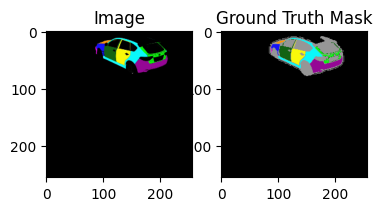

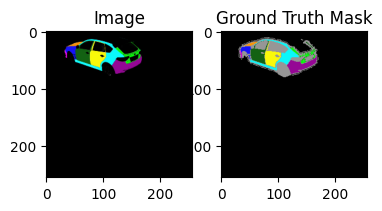

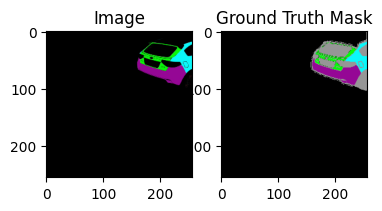

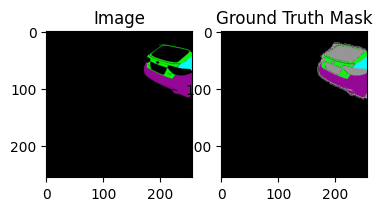

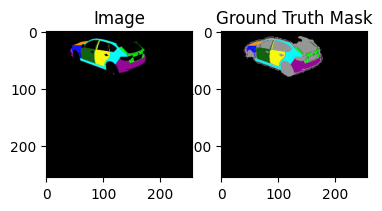

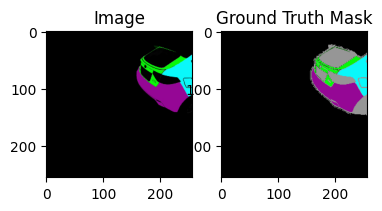

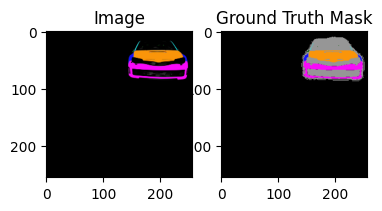

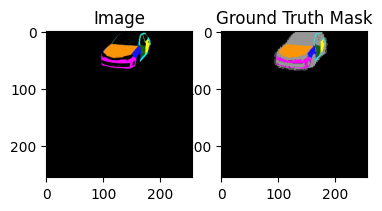

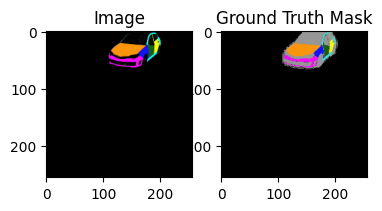

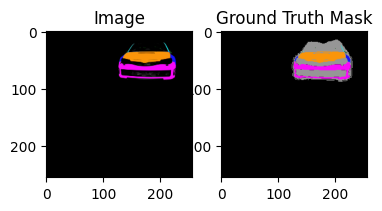

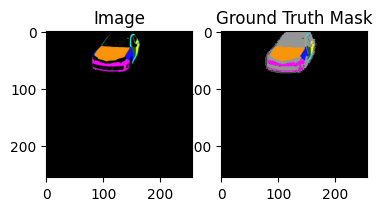

In [78]:
orange_im_path = "./data/carseg_data/images/orange_3_doors/with_segmentation"
black_im_path = "./data/carseg_data/images/black_5_doors/with_segmentation"
photo_im_path = "./data/carseg_data/images/photo/with_segmentation"

mask_name = "black_5_doors_"

#### CHECKING THE ORANGE CAR DATA 
index = 0 
for im in os.listdir(black_im_path):

    if im.endswith(".jpg") or im.endswith(".png"):
        # Load the image
        image_path = os.path.join(black_im_path, im)
        
        name, ext = im.split('.')
        mask_string = mask_name + name + ".npy"
        mask_path = os.path.join(masks_path, mask_string)
        mask = np.load(mask_path)
        mask = mask//10
        
        img = cv2.imread(image_path)
        resized = resize_with_pad(img, (256, 256))
        img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        colorize_segmentation_mask(mask, mask=True)
        plt.imshow(img_rgb)
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        # img_rgb = cv2.cvtColor(model_outputs_images[image_index_to_display], cv2.COLOR_BGR2RGB)
        plt.imshow(colorize_segmentation_mask(mask, mask=True))
        plt.title('Ground Truth Mask')

        if index == 10:
            break
        index = index + 1
        
    plt.show() 
        